In [42]:
from src.utils.utils import *
import os
import joblib

import datetime as dt
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from hdbscan import HDBSCAN

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

#### DESCARGA DE DATOS
  
Puedes descargar directamente los archivos desde los siguientes enlaces o ejecutar el código proporcionado.  
Estos archivos se descargan en formato zip y se deben descomprimir en la carpeta 'data_sample'.

**EFFIS** - [European Forest Fire Information System](https://forest-fire.emergency.copernicus.eu/) - datos de área quemada en formato `shapefile` (< 200 MB):
- [Burn Areas database](https://maps.effis.emergency.copernicus.eu/effis?service=WFS&request=getfeature&typename=ms:modis.ba.poly&version=1.1.0&outputformat=SHAPEZIP)

**Eurostat** - [GISCO](https://ec.europa.eu/eurostat/web/gisco/overview) - `shapefile` con los códigos internaciones de los países y sus nombres traducidos al inglés:
- [Countries](https://gisco-services.ec.europa.eu/distribution/v2/countries/shp/CNTR_RG_20M_2024_4326.shp.zip)

In [43]:
# Antes de nada crearemos la carpeta en dónde guardaremos los datos (incluida en .gitignore)
data_directory = './src/data_sample/shp'
os.makedirs(data_directory, exist_ok=True)

# Descagar de datos (< 200 MB en total)
urls = {
    'EFFIS':'https://maps.effis.emergency.copernicus.eu/effis?service=WFS&request=getfeature&typename=ms:modis.ba.poly&version=1.1.0&outputformat=SHAPEZIP',
    'Countries':'https://gisco-services.ec.europa.eu/distribution/v2/countries/shp/CNTR_RG_20M_2024_4326.shp.zip'
}

download_data(urls, data_directory)

#### CARGA DE DATOS

Los datos necesarios se encuentran en formato `shapefile`, el cual se divide en 4 archivos diferentes.  
Para importarlos a un dataframe usaremos la librería `geopandas`.

In [44]:
effis = gpd.read_file(os.path.join(data_directory,'modis.ba.poly.shp'))
countries = gpd.read_file(os.path.join(data_directory, 'CNTR_RG_20M_2024_4326.shp'))

In [45]:
effis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 76819 entries, 0 to 76818
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          76819 non-null  object  
 1   FIREDATE    76819 non-null  object  
 2   LASTUPDATE  76819 non-null  object  
 3   COUNTRY     76817 non-null  object  
 4   PROVINCE    76819 non-null  object  
 5   COMMUNE     76819 non-null  object  
 6   AREA_HA     76819 non-null  object  
 7   BROADLEA    76007 non-null  object  
 8   CONIFER     76007 non-null  object  
 9   MIXED       76007 non-null  object  
 10  SCLEROPH    76007 non-null  object  
 11  TRANSIT     76007 non-null  object  
 12  OTHERNATLC  76007 non-null  object  
 13  AGRIAREAS   76007 non-null  object  
 14  ARTIFSURF   76007 non-null  object  
 15  OTHERLC     76007 non-null  object  
 16  PERCNA2K    76819 non-null  object  
 17  CLASS       76819 non-null  object  
 18  geometry    76819 non-null  geometry
d

In [46]:
effis.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
0,2,2016-08-28 00:00:00,2022-01-26 11:57:54.973474,AL,Korcë,Konispol,67,0,0,0,19.402985074597908,16.417910447736688,10.447761194014257,53.731343283501886,0,0,0,FireSeason,"POLYGON ((20.18901 39.74908, 20.18909 39.75006..."
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,0,56.893956498833234,38.661849928501404,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((-8.06251 40.84474, -8.06033 40.8436,..."
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,0,67.05882352933287,19.99999999997647,11.7647058823391,0,0,0,FireSeason,"POLYGON ((-8.05657 41.40623, -8.05945 41.4048,..."
3,87,2016-07-27 00:00:00,2022-01-26 11:57:54.973474,TR,??rnak,N.A.,72,0,0,0,0,70.83333333323495,22.222222222191355,0,6.9444444444348,0,0,FireSeason,"POLYGON ((42.50247 37.53773, 42.5029 37.53451,..."
4,368,2016-08-24 00:00:00,2022-01-26 11:57:54.973474,IT,Genova,Bogliasco,267,11.654135338341485,5.639097744358783,0.37593984962391885,0,7.894736842102295,74.06015037591202,0.37593984962391885,0,0,5.453094633641743,FireSeason,"POLYGON ((9.06157 44.39255, 9.06266 44.39417, ..."


#### FILTRADO DE DATOS

Primero realizamos un filtrado de países para acotar a nuestro área de interés

In [6]:
# Nos fijamos en que el nombre de los países de EFFIS está codificado, 
# por lo que vamos a proceder a decodificarlo usando el shapefile de Eurostat.
# Además aprovechamos y filtramos por los países de la Europa geográfica:
# https://en.wikipedia.org/wiki/United_Nations_geoscheme?utm_source=chatgpt.com

# Excluiremos a Rusia Bielorrusia y Moldavia or carecer de datos y a Ucrania debido a la guerra 

'''
Países UE:
https://european-union.europa.eu/principles-countries-history/eu-countries_es#header_countries_list

'''

# Filtramos el dataset por los países de nuestra lista (lista de países en utils.py)
countries = countries[countries.NAME_ENGL.isin(eu_countries)]
effis_eu = effis[effis.COUNTRY.isin(filtro_paises(countries, eu_countries))] 

# Creamos un nuevo campo para el código del país (COUNTRY_ID) y sustituimos el campo 'COUNTRY' con el nombre en inglés
# Esto facilitará nuestro entendimiento de los datos cuando los analicemos
effis_eu['COUNTRY_ID'] = effis_eu.COUNTRY
effis_eu['COUNTRY'] = nombre_pais(countries, effis_eu.COUNTRY)

No se encuentra Kosovo


c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


A continuación, delimitamos un marco de trabajo, esto es, el área de estudio.  
Si bien el filtro anterior ya nos acota a los países de nuestro interés,  
con este marco se pretende descartar áreas de estos países fuera del continente europeo,  
como pueden ser las islas Canarias, Madeira y las islas Azores.  

Otra forma de abordar este estudio es definir directamente el marco de trabajo sin filtrar por países,  
pero en este caso he querido cerciorarme del área incluida, y excluir zonas de la península de Anatolia (Turquía),  
ya que se encuentran geográficamente en Asia, o Ucrania, que no tendría valores reales de incendios debido a la guerra. 

In [7]:
# Establecemos nuestro marco de trabajo y guardamos las coordenadas
# El filtrado lo haremos en un paso posterior 
# ya que tenemos que calcular primero las coordenadas para el dataset

lat_min = 34.8  # Isla de Gavdos, Grecia
lat_max = 71.2  # Cabo Norte, Noruega
lon_min = -10.5 # Dunmore Head, Irlanda
lon_max = 31.6  # Ilomantsi, Finlandia

marco = (lat_min, lat_max, lon_min, lon_max)

Para obtener las coordenadas puedes emplear estas funciones prestadas de [open-meteograms](https://github.com/vrieraj/open-meteograms/):

```python
    location = nominatim('tarifa')                  # Buscamos el lugar en nominatim
    ubicacion = info_ubicacion(location[0])         # Obtenemos la información del lugar seleccionado de la lista de nominatim
    lat, lon = ubicacion['lat'], ubicacion['lon']   # Obtenemos las coordenadas del diccionario con los atributos del lugar

#### PREPROCESADO DEL SHAPEFILE

A partir de aquí iremos trabajando con transformadores para crear un pipeline que nos permita automatizar todo el procesado de los datos.  
Al final del apartado crearemos y ejecutaremos el pipeline para no perder el hilo del proceso. 

La única premisa es NO emplear `ColumnTransformer`, ya que devuelve numpy arrays y perderíamos la estructura de geodataframe. 

**Cálculo del centroide y coordenadas**

Estableceremos las coordenadas de cada incendio en su centroide y ahora sí, filtramos por nuestro marco de trabajo establecido

In [8]:
def coords(X):
    # Reproyectamos capa, calculamos centroides y extraemos coordenadas
    X = X.to_crs(4326)
    X['LAT'], X['LON'] = X.centroid.y, X.centroid.x
    return X

# Usamos FunctionTransformer para el pipeline
calc_coords = FunctionTransformer(coords)

In [9]:
# En este caso, como nuestra función ha de admitir parámetros, los pasaremos como kw_args
# Otra opción es crear nuestro propio transformador. Una referencia aquí:
# https://towardsdatascience.com/creating-custom-transformers-for-sklearn-pipelines-d3d51852ecc1/

def bbox_filter(X,bbox):
    lat_min, lat_max, lon_min, lon_max = bbox
    return X.loc[
        X.LAT.between(lat_min, lat_max) &
        X.LON.between(lon_min, lon_max)
    ]

filter_bbox = FunctionTransformer(bbox_filter, kw_args={'bbox':marco})

# Para modificar el marco de trabajo bastará con:
# filter_bbox.set_params(kw_args={'bbox': nuevo_marco})

**Cálculo del tiempo**

A continuación calculamos día juliano y posbile duración de los incendios

In [10]:
def day_year(X):
    # Pasamos las columnas de inicio de incendio a datetime 
    X.FIREDATE = pd.to_datetime(X.FIREDATE, format='ISO8601')

    # Creamos una variable para los años y eliminamos los incendios del año en curso
    X['YEAR'] = X.FIREDATE.dt.year
    X = X[X.YEAR < dt.datetime.now().year]

    # Calculamos día juliano
    X['DAY_YEAR'] = X.FIREDATE.dt.dayofyear

    return X

calc_dayofyear = FunctionTransformer(day_year)

In [11]:
# Calculamos y revisamos la duración del incendio, pero los valores no parecen tener sentido
# Probablemente 'LASTUPDATE' esté ligado a la fecha de extinción del incendio, esto es, 
# cuando la autoridad competente lo determina, o última fecha que se detecta la 'huella' del incendio.
# En cualquier caso, no nos sirve este dato ya que se buscaba valorar la velocidad de propagación 

effis_eu.FIREDATE = pd.to_datetime(effis_eu.FIREDATE, format='ISO8601')
effis_eu.LASTUPDATE = pd.to_datetime(effis_eu.LASTUPDATE, format='ISO8601')

effis_eu['DURATION'] = effis_eu.LASTUPDATE - effis_eu.FIREDATE
effis_eu.DURATION.dt.days.describe()

c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a c

count    47551.000000
mean       308.694496
std        514.765907
min        -44.000000
25%          5.000000
50%         19.000000
75%        365.500000
max       2180.000000
Name: DURATION, dtype: float64

**Conversión variables numéricas**

Si nos fijamos, todas las variables del shapefile están formato texto, por lo que las convertiremos en números enteros y decimales, según qué variables

In [12]:
def conv_types(X):
    # Las siguientes variables hacen referencia al tipo de superficie quemada
    # expresada en porcentaje del área del incendio

    features_float = ['BROADLEA', 'CONIFER', 'MIXED', 'SCLEROPH', 'TRANSIT',
                    'OTHERNATLC', 'AGRIAREAS', 'ARTIFSURF', 'OTHERLC']

    X['AREA_HA'] = X.AREA_HA.astype(int)                # El área quemada viene en hectáreas completas
    X[features_float] = X[features_float].astype(float)

    return X

conv_num = FunctionTransformer(conv_types)

**Creación pipeline**

Agrupamos transformers en un pipeline y aplicamos el preprocesado de datos.  
De momento dejaremos `conv_num` fuera del pipeline para reorganizar después con las transformaciones

In [13]:
# Creación del pipeline

preprocessing = Pipeline([
                ('Calc_coords', calc_coords),
                ('Filter_area', filter_bbox),   # preprocessing.set_params(Filter_area__kw_args={'bbox': nuevo_bbox})
                ('Calc_dayofyear', calc_dayofyear)])
preprocessing

,steps,"[('Calc_coords', ...), ('Filter_area', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function coo...00216CCE34360>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [14]:
# Aplicación del preprocesado

effis_eu = preprocessing.fit_transform(effis_eu)
effis_eu = conv_num.fit_transform(effis_eu)
effis_eu.info()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9972\2560604230.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X['LAT'], X['LON'] = X.centroid.y, X.centroid.x


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 40941 entries, 0 to 66299
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   id          40941 non-null  object         
 1   FIREDATE    40941 non-null  datetime64[ns] 
 2   LASTUPDATE  40941 non-null  datetime64[ns] 
 3   COUNTRY     40941 non-null  object         
 4   PROVINCE    40941 non-null  object         
 5   COMMUNE     40941 non-null  object         
 6   AREA_HA     40941 non-null  int64          
 7   BROADLEA    40623 non-null  float64        
 8   CONIFER     40623 non-null  float64        
 9   MIXED       40623 non-null  float64        
 10  SCLEROPH    40623 non-null  float64        
 11  TRANSIT     40623 non-null  float64        
 12  OTHERNATLC  40623 non-null  float64        
 13  AGRIAREAS   40623 non-null  float64        
 14  ARTIFSURF   40623 non-null  float64        
 15  OTHERLC     40623 non-null  float64        
 16  P

c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### SELECCIÓN DE FEATURES

In [15]:
# Revisamos la distribución de las features, y vemos que los porcentajes de tipos de área quemada (bosques, agrícolas, artificiales, etc)
# no aporta mucha información, ya que sólo la categoría 'OTHERNATLC' ('Other Natural Landscapes') representa el 97% de la superficie quemada
# en un 25 % de los datos, y al menos el 40% en la mitad de ellos. Mientras que el resto de las categorías son meramente residuales. 

effis_eu.describe().T

,count,mean,min,25%,50%,75%,max,std
FIREDATE,40941,2021-10-29 13:11:39.961673984,2016-02-07 00:00:00,2020-08-17 11:18:00,2022-03-19 11:17:00,2023-06-01 01:00:00,2024-12-31 12:46:00,NaN
LASTUPDATE,40941,2022-10-20 13:46:12.640073984,2022-01-26 11:12:36.928620,2022-01-26 11:45:36.105094912,2022-03-31 14:08:46.889602048,2023-06-27 07:29:48.145906944,2025-03-10 16:27:34.119126,NaN
AREA_HA,40941.0,136.932146,0.0,8.0,26.0,74.0,96610.0,1023.268714
BROADLEA,40623.0,15.489652,0.0,0.0,0.0,16.666667,100.0,28.787398
CONIFER,40623.0,3.29681,0.0,0.0,0.0,0.0,100.0,15.480564
MIXED,40623.0,2.42985,0.0,0.0,0.0,0.0,100.0,12.803305
SCLEROPH,40623.0,6.576687,0.0,0.0,0.0,0.0,100.0,21.591243
TRANSIT,40623.0,12.663559,0.0,0.0,0.0,4.098693,100.0,27.247327
OTHERNATLC,40623.0,45.698428,0.0,0.0,40.0,97.959184,100.0,44.065258
AGRIAREAS,40623.0,13.320988,0.0,0.0,0.0,14.507135,100.0,24.60385


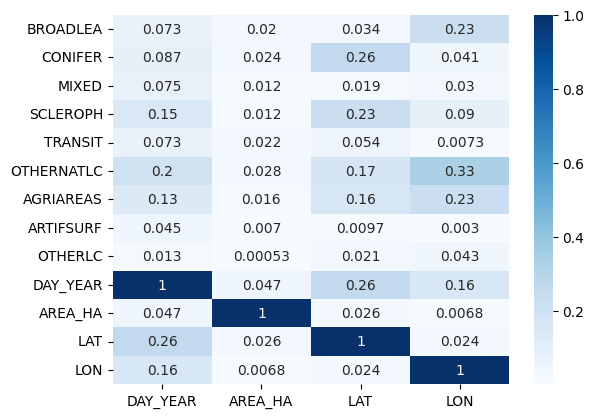

In [16]:
# Debido a la baja representatividad de las categorías de tipo de superficie quemada, consideraremos dos tipos de features:
# las features básicas de ubicación y tamaño de incendio, y las features de tipología de superficie quemada

features_base = ['DAY_YEAR','AREA_HA','LAT','LON']
features_type = ['BROADLEA', 'CONIFER', 'MIXED', 'SCLEROPH', 'TRANSIT', 'OTHERNATLC', 'AGRIAREAS', 'ARTIFSURF', 'OTHERLC']

# Para seleccionar las segundas variables miraremos la correlación de éstas con las principales

sns.heatmap(effis_eu[features_type + features_base].corr()[features_base].abs(), annot=True, fmt= ".2g", cmap='Blues');

Vayamos por partes:
- **BROADLEA** y **CONIFER** nos ayudarán a sesgar en diferentes longitudes y latitudes respectivamente
- **SCLEROPH** tiene una correlación similar a **CONIFER**
- **OTHERNATLC** tiene un 33% de correlación con **LON**, un 20% con **DAY_YEAR** y un poco menos con **LAT**
- **AGRIAREAS** tiene una distribución similar a **OTHERNATLC**, aunque con valores algo menores

Ahora comprobaremos correlación entre las diferentes variables y ver si podemos desartar alguna más. 
La idea es que en clusteres que abarquen un área muy grande, estas variables ayuden al algoritmo a diferenciar tipos de incendios, 
por ejemplo, en latitudes altas en dónde el número de incendios es menor. 

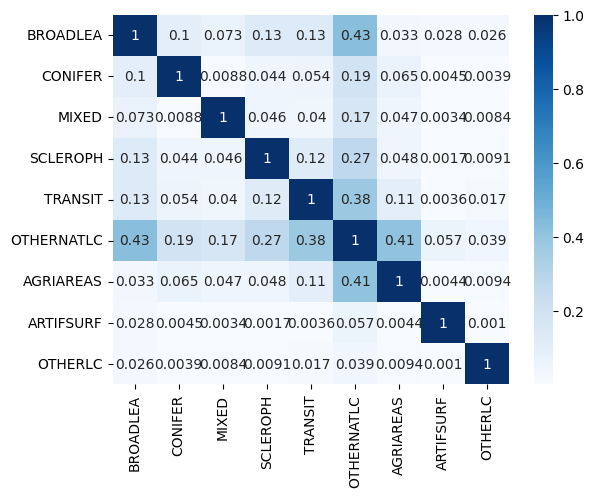

In [17]:
# Como vemos son variables independientes, por lo que pueden tratarse como variables categóricas (esto lo veremos en transformaciones)
# Destaca 'OTHERNATLC' por encima de todas, esto lo veo normal, ya que como he mencionado antes, aparece en casi todos los incendios

sns.heatmap(effis_eu[features_type].corr().abs(), annot=True, fmt= ".2g", cmap='Blues');

Finalmente nos quedaremos con las variables mencionadas anteriormente, salvo `OTHERNATLC`, ya que representa la categorías `Otros` en el tipo de vegetación, aparece en el 75% de los incendios y por tanto, se trata de una variable general que no discrimina zonas únicas. 

In [18]:
# Para la selección de features usaremos un FunctionTransformer tal como hicimos con el área de trabajo
# Ahora sólo crearemos el transformador, realizando el filtro cuando creemos el pipeline 

features_base = ['DAY_YEAR','AREA_HA','LAT','LON']
features_type = ['BROADLEA', 'CONIFER', 'SCLEROPH', 'AGRIAREAS']
features_select = features_base + features_type

def features_selection(X, columns):
    return X[columns]

select_cols = FunctionTransformer(features_selection, kw_args={'columns':features_select})    

# Para modificar las features bastará con:
# select_cols.set_params(kw_args={'columns': new_columns})

#### TRANSFORMACIÓN DE FEATURES

**Distribución de las variables:** `features_base`

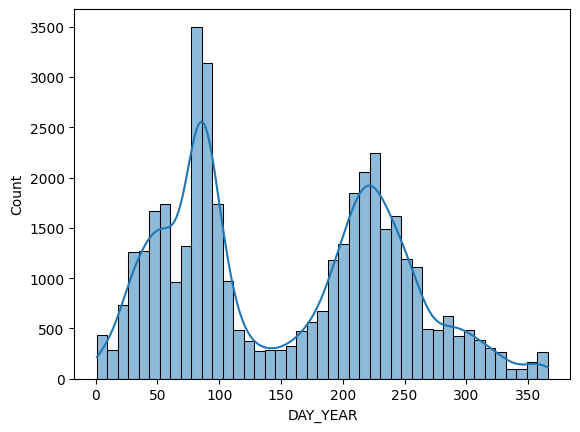

In [19]:
# Estudiamos ahora la distribución de incendios a lo largo del año, ya que se trata de una variable cíclica,
# y observamos que hay dos picos: en primavera y en verano

sns.histplot(effis_eu, x='DAY_YEAR', kde=True);

In [20]:
# La pregunta es, si manteniendo el orden cronológico de días, partiremos alguna agrupación temporal de incendios
# Para salir de dudas miramos los 10 días con menor número de incendios, y comprobamos que efectivamente se producen menos en diciembre
# Por tanto podemos dejar esta variable como está y asumiendo un 'parón' de incendios en esta época

def day2date(day:int):
    date = pd.to_datetime(day, format='%j').strftime('%d-%b')
    return date

for day in effis_eu.groupby('DAY_YEAR')['AREA_HA'].count().nsmallest(10).index:
    print(day2date(day))

08-Dec
01-Jan
04-Dec
05-Dec
02-Dec
09-Dec
13-Dec
06-Dec
16-Dec
07-Dec


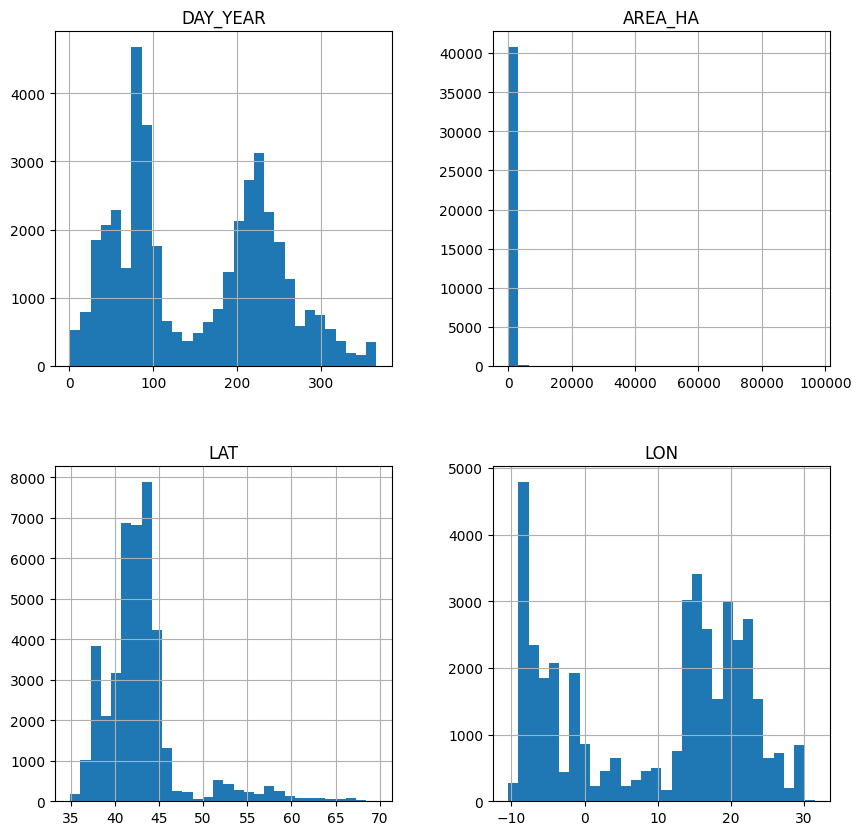

In [21]:
# Observamos ahora la distribución de las features que emplearemos: día del año, área quemada y coordenadas geográficas.
# Comprobamos que hay dos tipos de distribuciones: bimodal en el caso del día del año y longitud, y log-normal en el caso del área y latitud

# Aunque la distribución de las variables no es gaussiana, no las trasformaremos,
# ya que HDBSCAN reconoce clusters de densidad variable, y si lo hiciéramos no reconocería los clústeres naturales

effis_eu[features_base].hist(bins=30, figsize=(10,10));

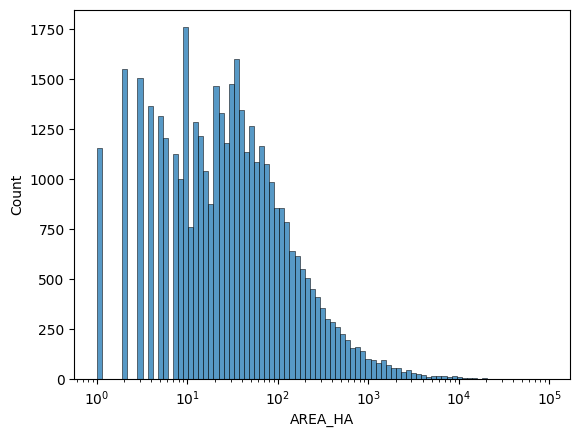

In [22]:
# No obstante, el área de los incendios tiene una distribución demsiado radical, por lo que la analizaremos independientemente
# Si nos fijamos, hay huecos en el área pequeña, no teniendo unos valores continuos hasta alcanzar las 10 ha aproximadamente
# Además, realmente una superficie tan pequeña no deberíamos de considerarla como incendio, y por tanto, filtraremos

sns.histplot(effis_eu, x='AREA_HA', log_scale=True);

**Distribución de las variables:** `features_type`

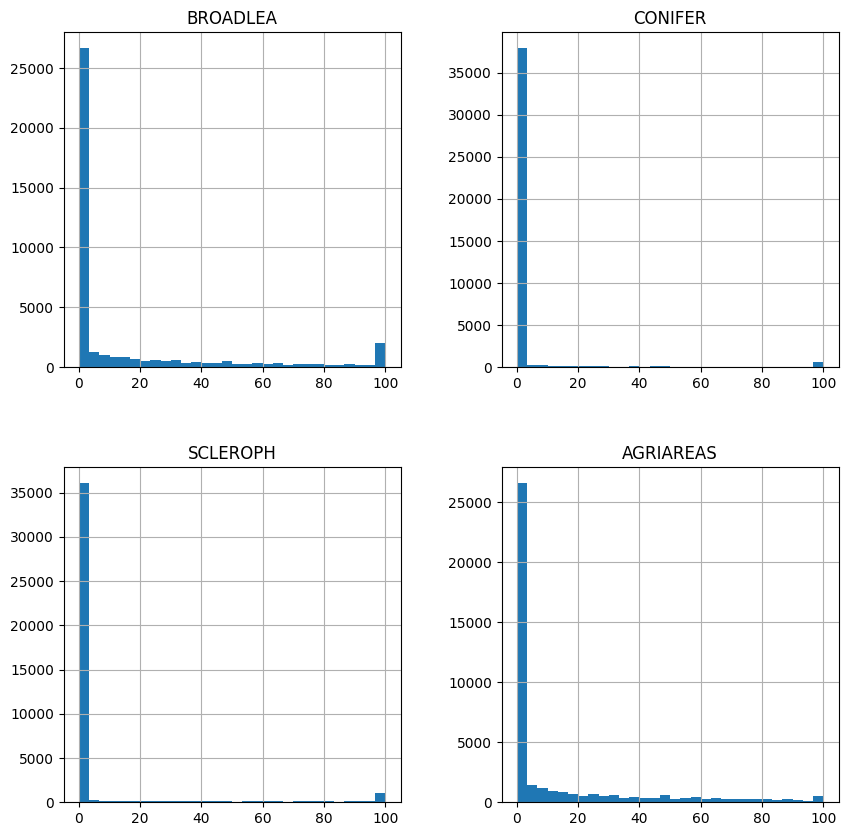

In [23]:
# Echamos un vistazo a las variables de tipología de área quemada
# Llama a atención que la distribución de las variables es similar a un capado, pero en el 0. 
# Además, el resto de porcentajes presenta una recurrencia irrisoria, si bien repunta algo en el 100 %.

effis_eu[features_type].hist(bins=30, figsize=(10,10));

Esto podemos reinterpretarlas como variables categóricas, ya que cada incendio tendrá, o no, ese tipo de terreno.  
Y dado la escasa representación de estas, nos servirán para discriminar clusteres en grandes zonas homogéneas (del dataset),  
ya que cada una representa una formación vegetal: 
- `BROADLEA` hace referencia a los bosques de frondosas (género *Quercus*, *Fagus sylvatica*, *Castanea sativa*...)
- `CONIFER` hace referencia a las coníferas (géneros *Pinus*, *Abies*, *Picea*...)  
- `SCLEROPH` hace referencia al bosque esclerófilo, propio de zonas mediterráneas
- `AGRIAREAS` hace referencia  las zonas agrícolas

Por tanto, realizaremos un One-Hot Encoding a cada una de estas variables.

**Transformación de features**

Llegados a este punto, repasamos lo que hemos realizado y adaptamos para filtrar `AREA_HA` y aplicar las transformaciones.

In [24]:
# Recapitulando, tenemos el pipeline del procesado del shapefile
# en dónde podemos ajustar 'bbox_filter' con el kw_args -> 'bbox' 

preprocessing

,steps,"[('Calc_coords', ...), ('Filter_area', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function coo...00216CCE34360>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [25]:
# También tenemos la selección de features
# con el kw_args -> 'columns'

select_cols

,func,<function fea...00216CCE34720>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,"{'columns': ['DAY_YEAR', 'AREA_HA', ...]}"
,inv_kw_args,None


In [26]:
# Ahora creamos un filtro de área usando otro FunctionTransformer
# y agregamos kw_args -> 'ha' para poder seleccionar el tamaño mínimo de incendios

def area_filter(X, ha):
    X.AREA_HA = X.AREA_HA.astype(int)
    X = X.loc[X.AREA_HA > ha]
    X.AREA_HA = np.log10(X.AREA_HA)     # Aplicamos logaritmo en base 10 (la mayor superficie es de 93,000 ha)
    return X

filter_area = FunctionTransformer(area_filter, kw_args={'ha':10})

In [27]:
# Creamos nuestro particular one-hot encoding para las features de tipo de vegetación
# y agregamos kw_args -> 'features' para poder modificar la lista de las mismas

def one_hot_features(X, features):
    X[features] = X[features].map(lambda x: 1 if x != 0 else x)
    return X

one_hot = FunctionTransformer(one_hot_features, kw_args={'features':features_type})

In [28]:
# Además de las transformaciones anteriores, aplicaremos un escalador,
# ya que lo modelos de cluster se basan en la distancia.
# Y ahora sí, creamos nuestro segundo pipeline

filter_transform = Pipeline([ 
    ('Feature_select', select_cols),
    ('Area_filter', filter_area),
    ('One-Hot', one_hot),
    ('MinMax', MinMaxScaler())
])
filter_transform

,steps,"[('Feature_select', ...), ('Area_filter', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function fea...00216CCE34720>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,"{'columns': ['DAY_YEAR', 'AREA_HA', ...]}"


In [29]:
# Aplicamos las transformaciones, no sin antes crear una copia de nuestro geodataframe con todas sus features 

X = filter_transform.fit_transform(effis_eu)
pd.DataFrame(X, columns=features_select)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9972\3633343322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.AREA_HA = X.AREA_HA.astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_9972\3633343322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.AREA_HA = np.log10(X.AREA_HA)     # Aplicamos logaritmo en base 10 (la mayor superficie es de 93,000 ha)


,DAY_YEAR,AREA_HA,LAT,LON,BROADLEA,CONIFER,SCLEROPH,AGRIAREAS
0,0.657534,0.198975,0.138356,0.735688,0.0,0.0,1.0,1.0
1,0.602740,0.857934,0.171319,0.054328,1.0,1.0,0.0,1.0
2,0.610959,0.219872,0.186350,0.057016,0.0,1.0,0.0,1.0
3,0.646575,0.351229,0.272623,0.468697,1.0,1.0,0.0,1.0
4,0.679452,0.380408,0.138770,0.041938,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
28840,0.706849,0.287730,0.182714,0.055261,0.0,0.0,0.0,1.0
28841,0.808219,0.047940,0.112830,0.086537,0.0,0.0,0.0,0.0
28842,0.849315,0.065837,0.274771,0.787956,1.0,0.0,0.0,0.0
28843,0.893151,0.071210,0.121249,0.878066,0.0,0.0,0.0,0.0


#### MODELADO

Para emplear [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html) tan sólo basta con indicarle el tamaño mínimo de elementos en cada cluster - `min_cluster_size` - ya que se basa en densidad dinámica, y por tanto, cambian las distancias entre vecinos. Adicionalmente, es recomendable ajustar otros hiperparámetros como `min_samples`, que influye en la robustez de los clusters frente al ruido.

Para nuestro caso, se ha comenzado con establecer `min_cluster_size` con el 0.1 % de las instancias del dataset, es decir, cada cluster deberá de tener al menos un 0.1 % del total de incendios. Con esto se pretende mantener el nivel de detalle deseado sin generalizar grandes zonas, y sin generar demasiado ruido. Además, también se ha establecido en 5 `mni_samples`, esto es, el número mínimo de vecinos de los elementos core del cluster, con el fin de asegurar unos clusters más robustos.

In [30]:
# Aproximación del número min de elementos para cada cluster
print(f'0.1 % del total del dataset: {round(X.shape[0] / 1000)}')

0.1 % del total del dataset: 29


In [31]:
# Sin embargo, tras varias pruebas la mejor combinación encontrada ha sido la siguiente

scan = HDBSCAN(min_cluster_size=50, min_samples=5)
scan.fit(X)

c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,min_cluster_size,50
,min_samples,5
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


**Evaluación del modelo**

Primero comprobamos el número de clusters y de anomalías y la persistencia de los clusters

In [32]:
num_clusters(scan, X)

# Clusteres con persitencia > 0.1
persistance(scan)

Clusteres: 52
Anomalías: 13.84 %



,Clusters,Persistance
0,36,0.413858
1,42,0.365610
2,40,0.243898
3,23,0.242530
4,22,0.229288
5,21,0.201217
6,49,0.193472
7,30,0.188045
8,35,0.169702
9,45,0.169367


Considerando que se busca una representación de los incendios 'tipo' en cada zona de Europa,  
veo un buen balance entre el número de clusters y el porcentaje de anomalías (incendios sin clasificar),  
ya que valores inferiores al 10 % suele arrojar > 100 clusters. 

La persistencia, aunque *a priori* pueda parecer baja, realmente es la más equilibrada encontrada.  
Debido a la variedad de incendios (con un rango de 10 - 93,000 ha), el tamaño del territorio, y los escasos datos,  
comprobaremos que es una buena representación de las principales zonas afectadas por incendios forestales. 

Solo resta revisar el resultado de la clusterización

c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Usuario\Documents\GitHub\ML_EFFIS\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


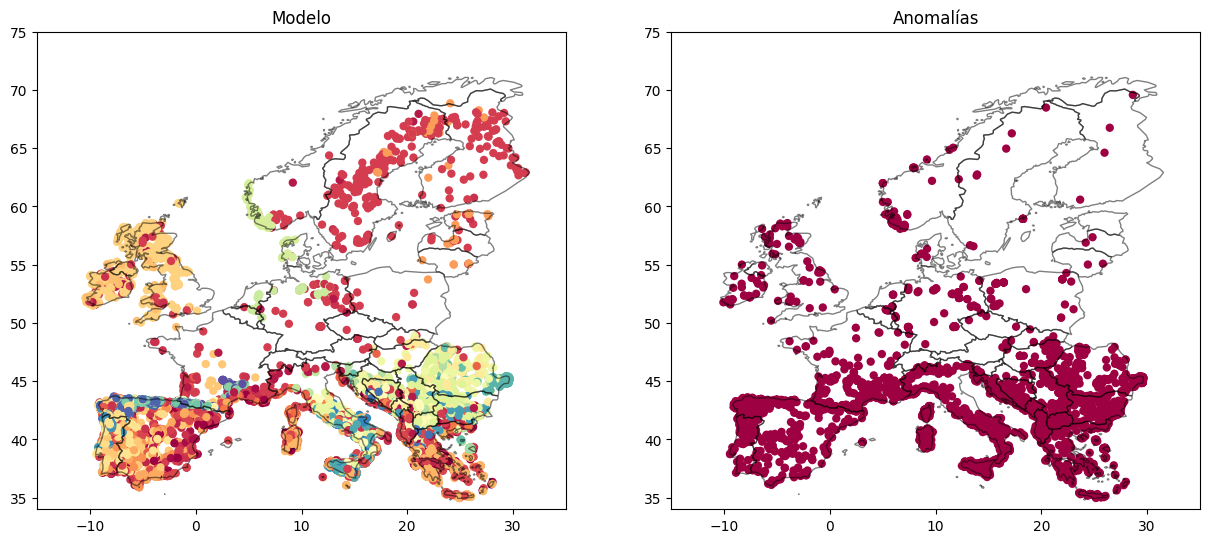

In [33]:
# Primero tenemos que traernos las etiquetas generadas por HDBSCAN a nuestro geodaataframe, 
# pero para ello primero hay que filtrarlo por superficies mayores a 10 ha

df = effis_eu.loc[effis_eu.AREA_HA > 10]    # filtramos el geodataframe
df['CLUSTER'] = scan.labels_                # obtenemos la serie de etiquetas generadas por el modelo
df['CLUSTER_PROB'] = scan.probabilities_    # y de paso la probabilidad de pertenecer a esa clase

clusters_anomalias(df, countries)           # visualizamos clusteres y anomalías

Y vemos que tenemos anomalías por todos lados. No obstante, hay que recordar que estas anomalías sólo representan el 13.84 % de todos los incendios mayores de 10 ha entre 2016 - 2024, es decir, 3993 de 28845 incendios.  
Además, al aparecer anomalías en la totalidad del territorio, hace pensar que estos incendios son los *outliers* de su zona, incendios raros, e incendios en zonas donde no suelen producirse, como al sur de Bélgica - norte de Francia, en la costa norte de Noruega, o en el límite de Suecia y Noruega, en donde vemos que los incendios detectados forman una franja muy delimitada, sin embargo las anomalías surgen en el límite de esta (un cambio de vegetación, quizás, que no concuerda con sus vecinos).  

En definitiva, parece una buena base para delimitar tipología de incendio en cada zona, y focalizar el problema, pudiendo compartir soluciones con zonas similares (ejemplo, España y Portugal o  España y Francia comparten tipologías de incendios, así como los países balcánicos), o por el contrario, centrarse en las anomalías y estudiar si están surgiendo incendios en zonas donde no suelen producirse, o en épocas diferentes (aquí no vemos las fechas), pero para ello, hará falta un EDA de estos datos con las etiquetas dadas.

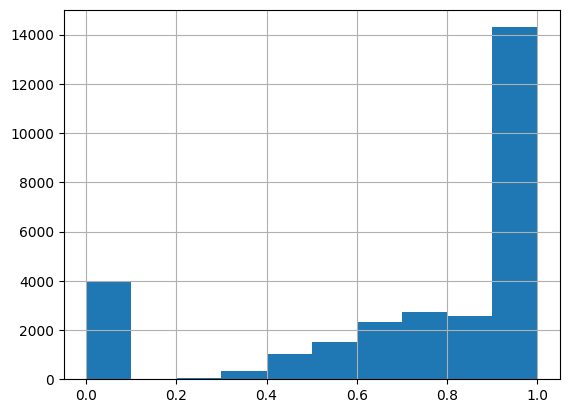

In [34]:
# También podemos ver las probabilidades de cada incendio de pertenecer a un cluster
# Y vemos que más de 16,000 incendios (frente a 28,000) se asignan con una seguridad del 80 % de probabilidad

df.CLUSTER_PROB.hist();

**Revisión de los resultados**

No vamos a realizar un EDA sobre los resultados, pero sí podemos ver qué dicen algunos de los clusters.  
Os dejo un par de funciones para que probéis ver algunos de los resultados.

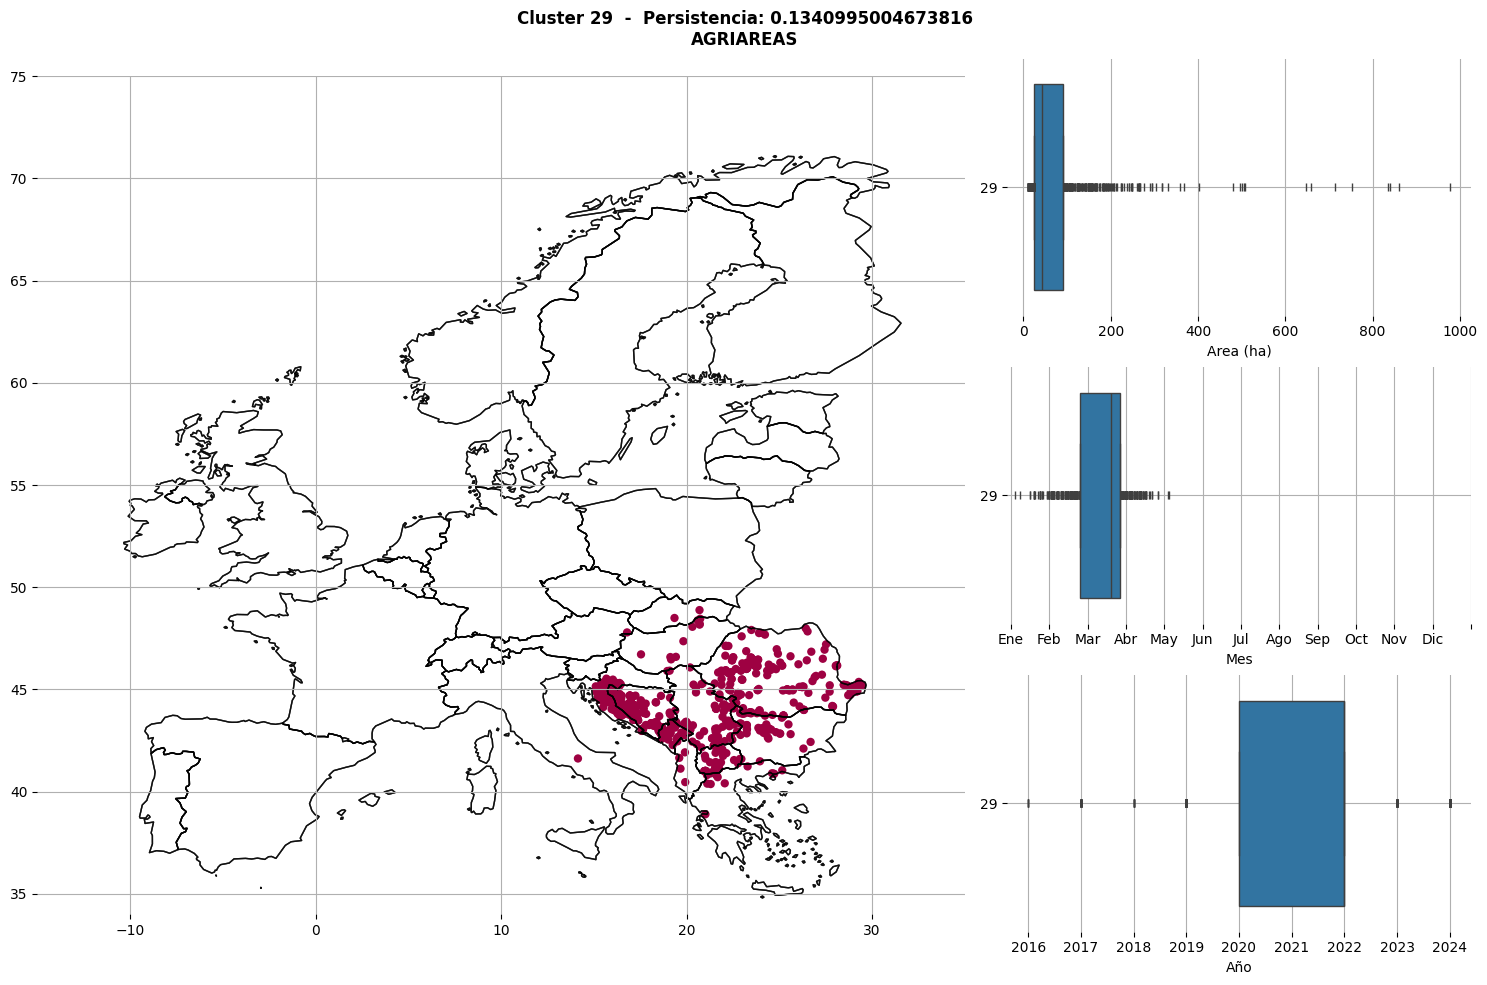

In [35]:
# Detalles de los clusters, también pueden verse las anomalías con el cluster -1
# Aunque por supuesto el dato de persistencia es erróneo debido a que no es un cluster en sí, si no incendios sin clasificar

cluster = 29
detalle_cluster(scan, df, cluster, countries)

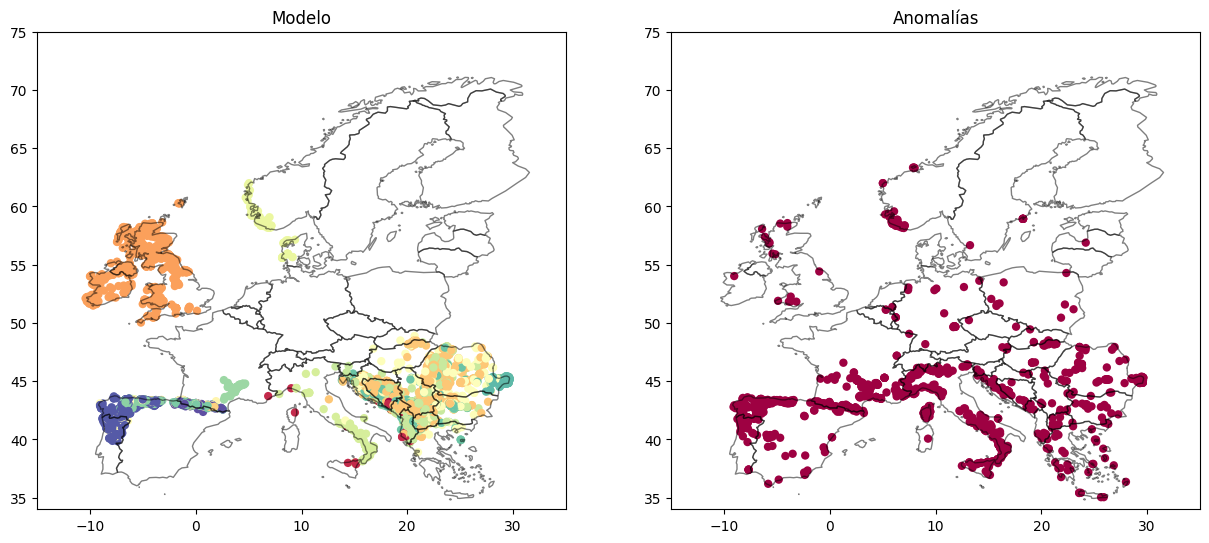

In [36]:
# Y también podemos comparar clusters por estacionalidad
# Para ello especifica el inicio y final del período que quieres comprobar en días julianos
# Ojo, sólo reconoce clusteres con la mitad de sus incendios en el período marcado

init, end = 31, 110
clusters_anomalias(df, countries, init, end)

#### EXPORTACIÓN DEL MODELO

Por último, vamos a crear un pipeline general junto al modelo y vamos a exportarlo para poder reusarse. 

In [37]:
# Creación de pipeline

EFFIS_SCAN = Pipeline([
    ('Preprocess_shp', preprocessing),
    ('Filter_transform', filter_transform),
    ('HDBSCAN', scan)
])

EFFIS_SCAN

,steps,"[('Preprocess_shp', ...), ('Filter_transform', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('Calc_coords', ...), ('Filter_area', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function coo...00216CCE34360>
,inverse_func,None
,validate,False


In [39]:
# Exportación con joblib
joblib.dump(EFFIS_SCAN, 'EFFIS_SCAN.joblib')

['EFFIS_SCAN.joblib']

Recuerda que puedes modificar algunos de los parámetros dados de la siguiente manera:

```python
EFFIS_SCAN.set_params(Preprocess_shp__Filter_area__kw_args={'bbox': nuevo_bbox})                -> Área de trabajo
EFFIS_SCAN.set_params(Filter_transform__Feature_select__kw_args={'columns': cols_to_filter})    -> Filtro de columnas dataset
EFFIS_SCAN.set_params(Filter_transform__Area_filter__kw_args={'ha':new_area})                   -> Área mínima de los incendios a considerar
EFFIS_SCAN.set_params(Filter_transform__One-Hot__kw_args={'features':new_features_list})        -> Variables 'tipo de vegetación'

De esta forma, podremos reutilizar HDBSCAN para categorizar incendios en un área de estudio dada, con datos de EFFIS, o con otros datos similares, esto es, desde un shapefile con los mismos nombres de atributos que en EFFIS.  

Realmente, tan solo necesitamos la fecha, el área y las coordenadas del incedio. Las demás variables (`'BROADLEA', 'CONIFER', 'SCLEROPH', 'AGRIAREAS'`) al ser binarias y muy generales, son fácilmente reproducibles en nuestra base de datos.